In [1]:
### Install requirements.txt
from anomalib.data import Folder
from anomalib.models import Ganomaly
from anomalib.engine import Engine
import sys
from PIL import Image
from anomalib.deploy import TorchInferencer
import numpy as np
import cv2
from torch import as_tensor
from torchvision.transforms.v2.functional import to_dtype, to_image
import torch
import torchvision.models as models
from anomalib import TaskType
from anomalib.deploy import ExportType
import matplotlib.pyplot as plt
from torchvision.transforms.v2 import Compose, Resize, CenterCrop, Normalize
import time
import os
import json
import shutil
from collections import defaultdict

### You should set up a python 3.11.x version to virtual environment to avoid any possible dependency issues

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.
<frozen importlib.util>:262: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
C:\Users\Fitra\AppData\Roaming\Python\Python311\site-packages\wandb\apis\public.py:3080: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version
C:\Users\Fitra\AppData\Roaming\Python\Python311\site-packages\pkg_resources\__init__.py:3147: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  de

In [2]:
# Setting paths
roboflow_path = "C:/Users/Fitra/Downloads/anomaly-detect/Anomaly Product.v2i.coco"  # Change to your Roboflow dataset path
anomalib_path = "C:/Users/Fitra/Downloads/anomaly-detect/datasets"  # Path for restructured dataset

# Create folder structure for Anomalib dataset
os.makedirs(os.path.join(anomalib_path, "normal"), exist_ok=True)
os.makedirs(os.path.join(anomalib_path, "abnormal"), exist_ok=True)

# Define categories mapping - without category 2
category_map = {
    0: "defect",
    1: "damaged",
    3: "good",  # This is the normal category
    4: "missing_component",
    5: "open",
    6: "scratch", 
    7: "stained"
}

# Create subfolders for each abnormal category
for cat_id, cat_name in category_map.items():
    if cat_id != 3:  # Not 'good'
        os.makedirs(os.path.join(anomalib_path, "abnormal", cat_name), exist_ok=True)

# Create a general "other" category for any unmapped categories
os.makedirs(os.path.join(anomalib_path, "abnormal", "other"), exist_ok=True)

# Process all splits (train, valid, test)
splits = ["train", "valid", "test"]
for split in splits:
    # Read annotation file
    annotation_path = os.path.join(roboflow_path, split, "_annotations.coco.json")
    with open(annotation_path, 'r') as f:
        annotations = json.load(f)
    
    # Map image_id to filename
    image_map = {img["id"]: img["file_name"] for img in annotations["images"]}
    
    # Group annotations by image_id
    image_categories = defaultdict(list)
    for ann in annotations["annotations"]:
        image_categories[ann["image_id"]].append(ann["category_id"])
    
    # Process each image
    for img_id, categories in image_categories.items():
        # Get image filename
        filename = image_map[img_id]
        src_path = os.path.join(roboflow_path, split, filename)
        
        # Determine target path based on categories
        is_normal = all(cat == 3 for cat in categories)  # Category 3 is "good"
        
        if is_normal:
            # For normal images
            dst_path = os.path.join(anomalib_path, "normal", filename)
        else:
            # For abnormal images - try to use first non-normal category that's in our map
            valid_abnormal_cats = [cat for cat in categories if cat != 3 and cat in category_map]
            
            if valid_abnormal_cats:
                # Use the first valid category
                abnormal_cat = valid_abnormal_cats[0]
                category_name = category_map[abnormal_cat]
            else:
                # If no valid abnormal categories, use "other"
                category_name = "other"
                
            dst_path = os.path.join(anomalib_path, "abnormal", category_name, filename)
        
        # Copy the image
        shutil.copy2(src_path, dst_path)

print("Dataset reorganization complete!")

Dataset reorganization complete!


In [3]:
# Use Anomalib with the reorganized dataset
datamodule = Folder(
    name="anomaly_detection",
    root=anomalib_path,
    normal_dir="normal",
    abnormal_dir="abnormal",
    train_batch_size=16,
    eval_batch_size=16,
    num_workers=4
)

# Choose model - GANomaly doesn't use a backbone parameter
from anomalib.models import Ganomaly
model = Ganomaly()

# Configure the engine
engine = Engine(
    max_epochs=20,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu'
)

# Train the model
engine.fit(datamodule=datamodule, model=model)

# Export the model
path_export_weights = engine.export(export_type=ExportType.TORCH,
                                    model=model)

INFO:anomalib.models.components.base.anomalib_module:Initializing Ganomaly model.
INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning_fabric.utilities.rank_zero:You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:anomalib.data.datamodules.base.image:No normal test images found. Sampling from training set using ratio of 0.20
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type              | Params | Mode 
--------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

C:\Users\Fitra\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\core\module.py:512: You called `self.log('generator_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
C:\Users\Fitra\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
C:\Users\Fitra\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\core\module.py:512: You called `self.log('discriminator_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:anomalib.callbacks.timer:Training took 3286.71 seconds
INFO:root:Exported model to C:\Users\Fitra\Downloads\anomaly-detect\src\results\Ganomaly\anomaly_detection\latest\weights\torch\model.pt


In [4]:
# Helper function to check if an image is in color or grayscale
def img_is_color(img):
    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same
        c1, c2, c3 = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True
    return False

# Function to display a list of images in a grid
def show_image_list(list_images, path_image, list_titles=None, list_cmaps=None, grid=True, num_cols=2, figsize=(20, 10),
                    title_fontsize=30):
    '''
    Shows a grid of images, where each image is a Numpy array. The images can be either
    RGB or grayscale.

    Parameters:
    ----------
    images: list
        List of the images to be displayed.
    list_titles: list or None
        Optional list of titles to be shown for each image.
    list_cmaps: list or None
        Optional list of cmap values for each image. If None, cmap will be
        automatically inferred.
    grid: boolean
        If True, show a grid over each image
    num_cols: int
        Number of columns to show.
    figsize: tuple of width, height
        Value to be passed to pyplot.figure()
    title_fontsize: int
        Value to be passed to set_title().
    '''

    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images = len(list_images)
    num_cols = min(num_images, num_cols)
    num_rows = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Create list of axes for easy iteration
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):
        img = list_images[i]
        title = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        cmap = list_cmaps[i] if list_cmaps is not None else (None if img_is_color(img) else 'gray')

        list_axes[i].imshow(img, cmap=cmap)
        list_axes[i].set_title(title, fontsize=title_fontsize)
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    plt.savefig(path_image)
    _ = plt.show()

Inference Time: 211.66 ms
Abnormal - pred_score: 0.7552


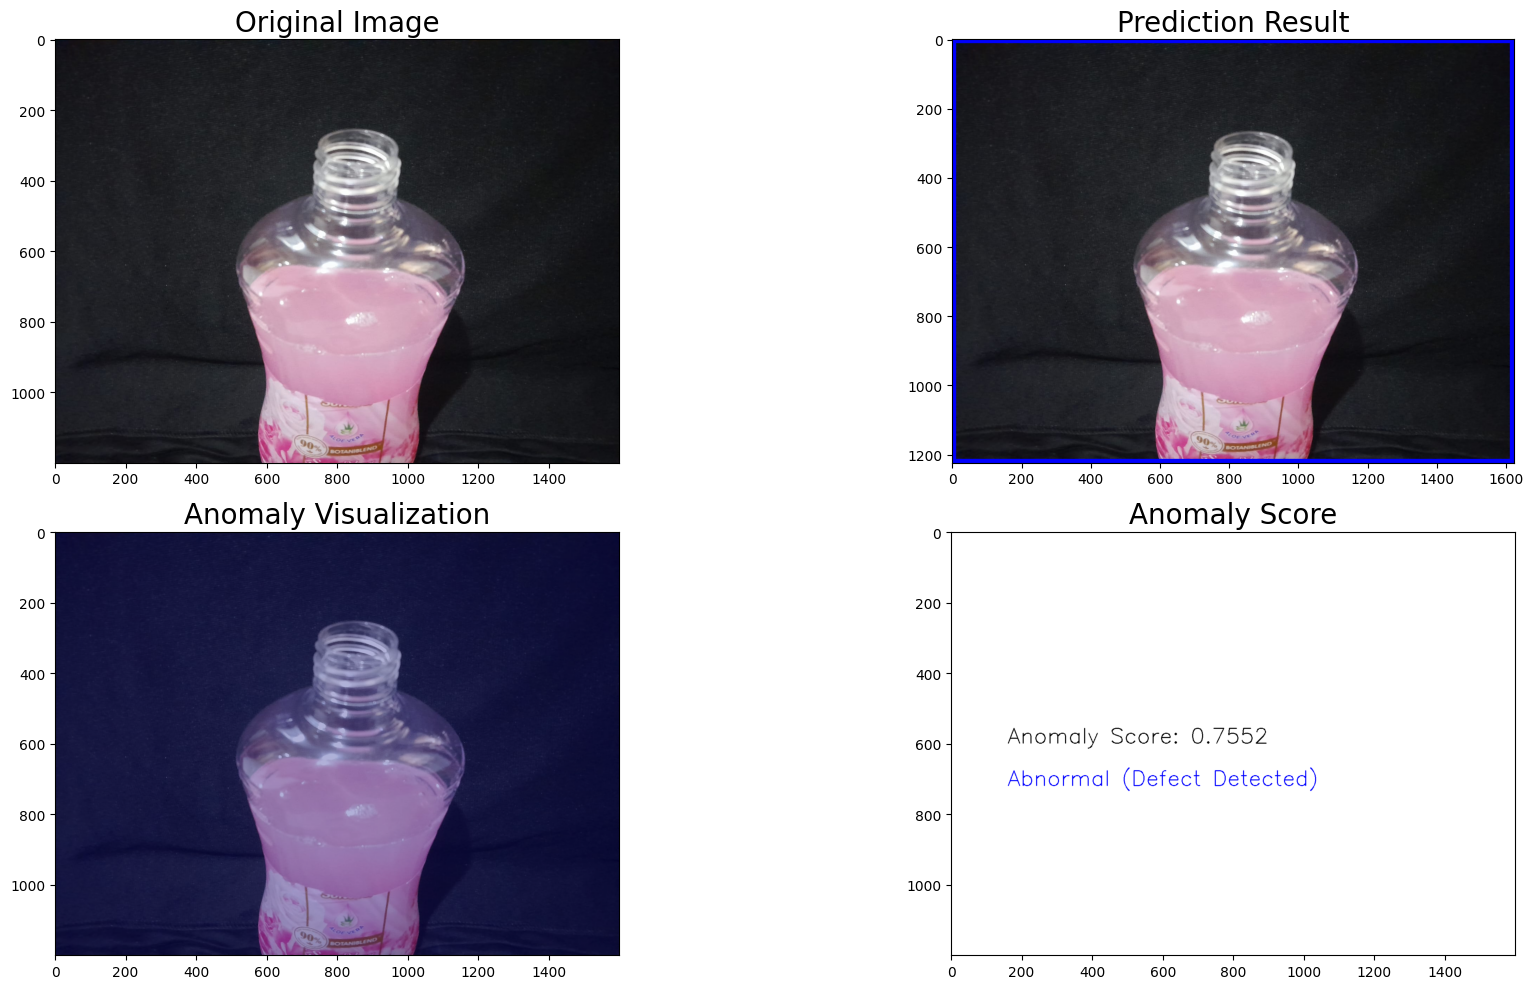

In [6]:
# Test model on a sample image from the test set
test_image_path = "C:/Users/Fitra/Downloads/anomaly-detect/datasets/defect/missing component/WhatsApp Image 2025-04-20 at 16.52.51_7b23de72.jpg"

# Load the exported model
inferencer = TorchInferencer(path=path_export_weights, device="gpu" if torch.cuda.is_available() else "cpu")

# Timing inference
start_time = time.time()
result = inferencer.predict(image=test_image_path)
end_time = time.time()
inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
print(f"Inference Time: {inference_time:.2f} ms")

# Display results
if result.pred_label == 0:
    normal_score = 1 - result.pred_score
    print("Normal - pred_score: {:.4f}".format(normal_score.item()))
    defect_type = "Normal (No Defect)"
else:
    print("Abnormal - pred_score: {:.4f}".format(result.pred_score.item()))
    defect_type = "Abnormal (Defect Detected)"

# Process image
image_np = result.image.cpu().numpy()
if len(image_np.shape) > 3:
    image_np = image_np[0]  # Get first image if batch dimension exists

# Transpose image if needed
if len(image_np.shape) == 3 and image_np.shape[0] == 3:  # (C,H,W) format
    image_np = np.transpose(image_np, (1, 2, 0))

# Convert image to uint8
image_uint8 = (image_np * 255).astype(np.uint8)

# For models without pixel-wise masks like GANomaly, create a simple visualization
image_with_text = image_uint8.copy()
h, w = image_with_text.shape[:2]

# Add text with prediction result
font = cv2.FONT_HERSHEY_SIMPLEX
text_position = (int(w * 0.05), int(h * 0.1))
font_scale = max(1, int(min(h, w) / 500))  # Scale text based on image size
thickness = max(2, int(min(h, w) / 500))

# Add colored border based on prediction
border_color = (0, 255, 0) if result.pred_label == 0 else (0, 0, 255)  # Green for normal, Red for abnormal
border_thickness = max(5, int(min(h, w) / 100))
image_with_border = cv2.copyMakeBorder(image_with_text, 
                                      border_thickness, border_thickness, 
                                      border_thickness, border_thickness, 
                                      cv2.BORDER_CONSTANT, 
                                      value=border_color)

# Create a simple heatmap (for visualization purposes)
# Since GANomaly doesn't provide pixel-wise masks, this is just a placeholder
simple_heatmap = np.ones((h, w), dtype=np.uint8) * (255 if result.pred_label == 1 else 0)
heatmap_colored = cv2.applyColorMap(simple_heatmap, cv2.COLORMAP_JET)

# Create a simple overlay
overlay = cv2.addWeighted(image_uint8, 0.7, heatmap_colored, 0.3, 0)

# Create a visualization of the anomaly score
score_viz = np.ones((h, w, 3), dtype=np.uint8) * 255  # White background
score_text = f"Anomaly Score: {result.pred_score.item():.4f}"
cv2.putText(score_viz, score_text, (int(w * 0.1), int(h * 0.5)), 
            font, font_scale, (0, 0, 0), thickness)
cv2.putText(score_viz, defect_type, (int(w * 0.1), int(h * 0.6)), 
            font, font_scale, (0, 0, 255) if result.pred_label == 1 else (0, 255, 0), thickness)

# Visualize results
path_result = "./result_visualization.png"
show_image_list(
    list_images=[image_uint8, image_with_border, overlay, score_viz],
    list_titles=['Original Image', 'Prediction Result', 'Anomaly Visualization', 'Anomaly Score'],
    num_cols=2,
    figsize=(20, 10),
    grid=False,
    title_fontsize=20,
    path_image=path_result
)

Loading model from C:\Users\Fitra\Downloads\anomaly-detect\src\results\Ganomaly\anomaly_detection\latest\weights\torch\model.pt
Found 452 normal images


Normal images: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


Found 36 abnormal images in category 'damaged'


damaged images: 100%|██████████| 10/10 [00:01<00:00,  9.21it/s]


Found 0 abnormal images in category 'defect'


defect images: 0it [00:00, ?it/s]


Found 3 abnormal images in category 'missing_component'


missing_component images: 100%|██████████| 3/3 [00:00<00:00,  8.55it/s]


Found 104 abnormal images in category 'open'


open images: 100%|██████████| 10/10 [00:01<00:00,  9.64it/s]


Found 42 abnormal images in category 'other'


other images: 100%|██████████| 10/10 [00:01<00:00,  8.85it/s]


Found 80 abnormal images in category 'scratch'


scratch images: 100%|██████████| 10/10 [00:01<00:00,  9.44it/s]


Found 1 abnormal images in category 'stained'


stained images: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


Successfully processed 64 images

MODEL EVALUATION METRICS
Accuracy:  0.7031
Precision: 0.7119
Recall:    0.9545
F1 Score:  0.8155


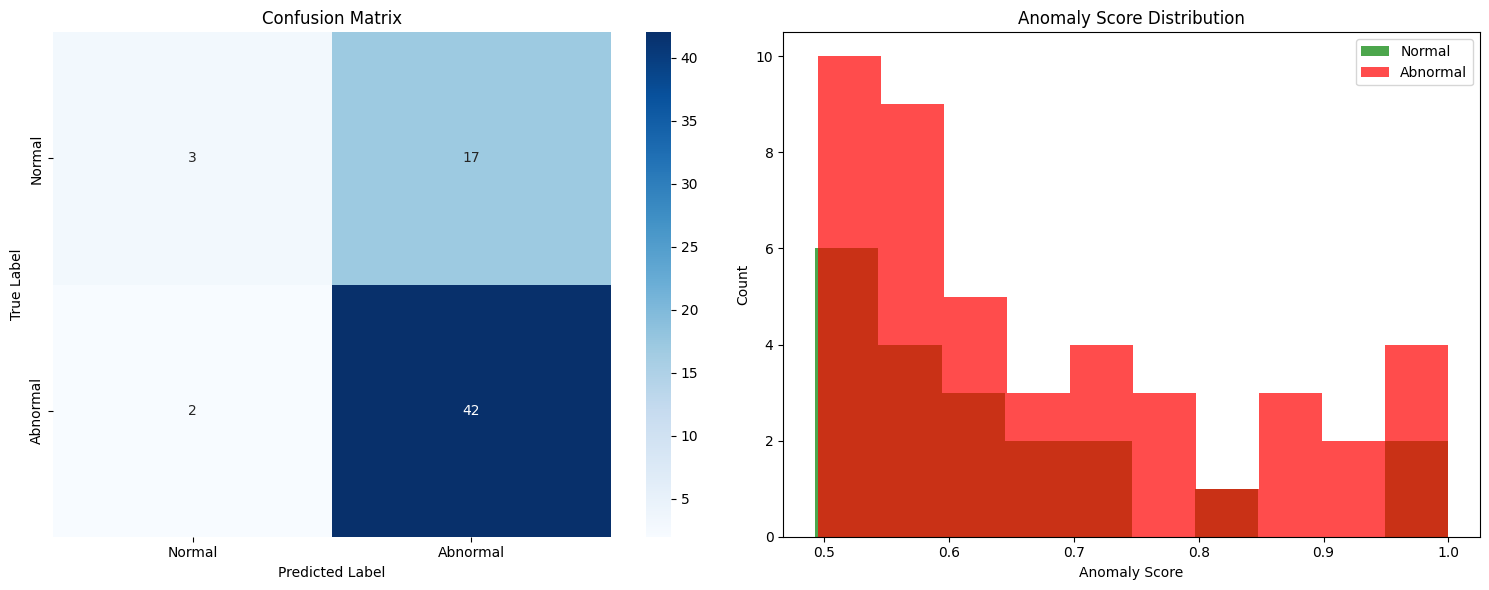

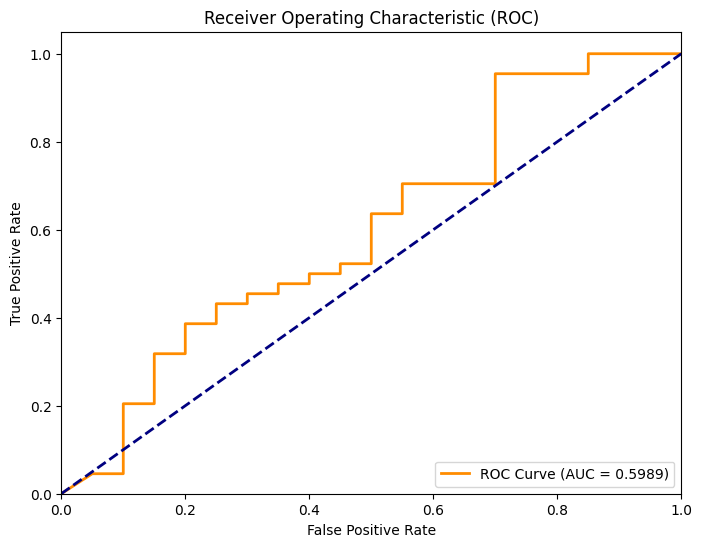

In [11]:
# Simpler model evaluation function that carefully handles CUDA tensors
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

def evaluate_model_simple(model_path, dataset_path, device='cuda'):
    """
    A simpler evaluation function with careful handling of GPU tensors
    """
    print(f"Loading model from {model_path}")
    inferencer = TorchInferencer(path=model_path, device=device)
    
    # Storage for results
    true_labels = []
    pred_labels = []
    scores = []
    
    # Test normal images
    normal_dir = os.path.join(dataset_path, "normal")
    if os.path.exists(normal_dir):
        normal_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png']:
            normal_files.extend(glob.glob(os.path.join(normal_dir, "**", ext), recursive=True))
        
        print(f"Found {len(normal_files)} normal images")
        for img_path in tqdm(normal_files[:20], desc="Normal images"):  # Limit to 20 images
            try:
                # Get prediction
                result = inferencer.predict(image=img_path)
                
                # IMPORTANT: Properly handle CUDA tensors
                if hasattr(result, 'pred_score') and isinstance(result.pred_score, torch.Tensor):
                    score = float(result.pred_score.cpu().item())  # Convert tensor to Python float
                else:
                    score = float(result.pred_score)  # Ensure it's a Python float
                
                # Convert pred_label to Python int (not tensor)
                if isinstance(result.pred_label, torch.Tensor):
                    label = int(result.pred_label.cpu().item()) 
                else:
                    label = int(result.pred_label)
                
                # Store results as Python primitive types (not tensors)
                true_labels.append(0)  # Normal class
                pred_labels.append(label)
                scores.append(score)
                
            except Exception as e:
                print(f"Error processing normal image {img_path}: {e}")
    
    # Test abnormal images
    abnormal_dir = os.path.join(dataset_path, "abnormal")
    if os.path.exists(abnormal_dir):
        # Get all category directories
        categories = [d for d in os.listdir(abnormal_dir) 
                     if os.path.isdir(os.path.join(abnormal_dir, d))]
        
        for category in categories:
            category_dir = os.path.join(abnormal_dir, category)
            abnormal_files = []
            for ext in ['*.jpg', '*.jpeg', '*.png']:
                abnormal_files.extend(glob.glob(os.path.join(category_dir, ext)))
            
            print(f"Found {len(abnormal_files)} abnormal images in category '{category}'")
            for img_path in tqdm(abnormal_files[:10], desc=f"{category} images"):  # Limit to 10 per category
                try:
                    # Get prediction
                    result = inferencer.predict(image=img_path)
                    
                    # IMPORTANT: Properly handle CUDA tensors
                    if hasattr(result, 'pred_score') and isinstance(result.pred_score, torch.Tensor):
                        score = float(result.pred_score.cpu().item())  # Convert tensor to Python float
                    else:
                        score = float(result.pred_score)  # Ensure it's a Python float
                    
                    # Convert pred_label to Python int (not tensor)
                    if isinstance(result.pred_label, torch.Tensor):
                        label = int(result.pred_label.cpu().item())  
                    else:
                        label = int(result.pred_label)
                    
                    # Store results as Python primitive types (not tensors)
                    true_labels.append(1)  # Abnormal class
                    pred_labels.append(label)
                    scores.append(score)
                    
                except Exception as e:
                    print(f"Error processing abnormal image {img_path}: {e}")
    
    # Check if we have any results
    if len(true_labels) == 0:
        print("No images were processed successfully. Please check paths and file formats.")
        return None
    
    print(f"Successfully processed {len(true_labels)} images")
    
    # Calculate metrics using pure Python lists (no tensors)
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='binary')
    recall = recall_score(true_labels, pred_labels, average='binary')
    f1 = f1_score(true_labels, pred_labels, average='binary')
    cm = confusion_matrix(true_labels, pred_labels)
    
    # Print metrics
    print("\n" + "="*50)
    print("MODEL EVALUATION METRICS")
    print("="*50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("="*50)
    
    # Create basic visualizations
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')
    axes[0].set_xticklabels(['Normal', 'Abnormal'])
    axes[0].set_yticklabels(['Normal', 'Abnormal'])
    
    # Score distribution
    true_normal = [scores[i] for i in range(len(scores)) if true_labels[i] == 0]
    true_abnormal = [scores[i] for i in range(len(scores)) if true_labels[i] == 1]
    
    axes[1].hist(true_normal, bins=10, alpha=0.7, label='Normal', color='green')
    axes[1].hist(true_abnormal, bins=10, alpha=0.7, label='Abnormal', color='red')
    axes[1].set_title('Anomaly Score Distribution')
    axes[1].set_xlabel('Anomaly Score')
    axes[1].set_ylabel('Count')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('model_performance.png')
    plt.show()
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(true_labels, scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall, 
        'f1': f1,
        'roc_auc': roc_auc,
        'true_labels': true_labels,
        'pred_labels': pred_labels,
        'scores': scores
    }

# Run the evaluation
metrics = evaluate_model_simple(
    model_path=path_export_weights,
    dataset_path=anomalib_path,
    device="cuda" if torch.cuda.is_available() else "cpu"
)